# Modeling True Positive and True Negative rates

We want to use the Bivariate Beta distribution built in the previous
sections. Before integrating it to the whole model, we consider a model for
sensibility and sensitivity as follows: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ individuals who
were exposed to a disease, and $Y_n$ denote the number of negative tests in
$n_{neg}$ not exposed. The person is tested with a gold standard, which is the
best benchmark and the most accurate possible.

Remind that the sensitivity $\gamma_s$ is the probability of a test being positive given
the exposition, while the specificity $\gamma_e$ is the probability of a
negative test given the non-exposition. 
Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. 
Besides that, there are two different models to handle with
$\alpha = (\alpha_1, \dots, \alpha_4)$. 

I. $\alpha_i \sim \operatorname{Gamma}(a^i, b^i)$, with $a^i$ and $b^i$ fixed. 

II. $\alpha_i \sim \operatorname{Dirac}(\hat{\alpha}_i)$ such that $\hat{\alpha}_i$
is calculated as explained before. 

In [1]:
import numpy as np
import pystan as ps

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

## Model 

First we code the model in Stan and use PyStan as a Python interface. 

In [2]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data and parameter blocks

Observe that we have a boolean variable to distinguish both models. 

In [3]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}' + structure[2]+'}') 

data {
    int<lower = 0> n_pos;
    int<lower = 0> n_neg; 
    int Y_p;
    int Y_n;
    vector<lower = 0>[4] alpha_data;
}
parameters {
    simplex[4] U; 
}
transformed parameters{ 
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec; 
    sens = U[1] + U[2];
    spec = U[1] + U[3];
}


### Model block 

In [4]:
print(structure[3] + '}') 


model {
    U ~ dirichlet(alpha_data);
    Y_p ~ binomial(n_pos, sens);
    Y_n ~ binomial(n_neg, spec);
}


## Toy example 

First we need to test the model with fake data. This is done to verify how the it behaves in a controlled space. 

In [5]:
n_pos = 50
n_neg = 45

sens = 0.8 
spec = 0.9

Y_p = np.random.binomial(n = n_pos, p = sens)
Y_n = np.random.binomial(n = n_neg, p = spec)

m1, m2, v1, v2, rho = sens, spec, (0.05)**2, (0.05)**2, -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, c = [1,1,1,1])

Notice that the estimated values are below: 

In [6]:
BivariateBeta().moments_calculus(solution.x)

(0.7605623296496768,
 0.8451218912863919,
 0.002887243844580008,
 0.002075226777743346,
 -0.2401950888936926)

In [7]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": solution.x
}

In [8]:
fit = sm.sampling(data=data, iter=5000)

In [9]:
fit

Inference for Stan model: anon_model_283154543b71871021ef1d48f344f3a6.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]         0.66  8.0e-4   0.05    0.56    0.63    0.66    0.7   0.75   3616    1.0
U[2]         0.11  5.1e-4   0.03    0.06    0.09    0.11   0.13   0.18   3484    1.0
U[3]         0.23  6.9e-4   0.04    0.15     0.2    0.23   0.26   0.32   3640    1.0
U[4]       3.1e-4  2.0e-5 1.5e-3 5.6e-17 9.9e-14 3.7e-10 1.1e-6 3.8e-3   6263    1.0
sens         0.77  6.9e-4   0.04    0.68    0.74    0.77    0.8   0.85   3643    1.0
spec         0.89  5.2e-4   0.03    0.82    0.87    0.89   0.91   0.94   3468    1.0
U_prior[1]   0.61  6.4e-4   0.06    0.48    0.57    0.61   0.65   0.72   9372    1.0
U_prior[2]   0.15  4.6e-4   0.05    0.08    0.12    0.15   0.18   0.25   9834    1.0
U_prior[3]   0.24  5.4e-4   0.05    0.14     

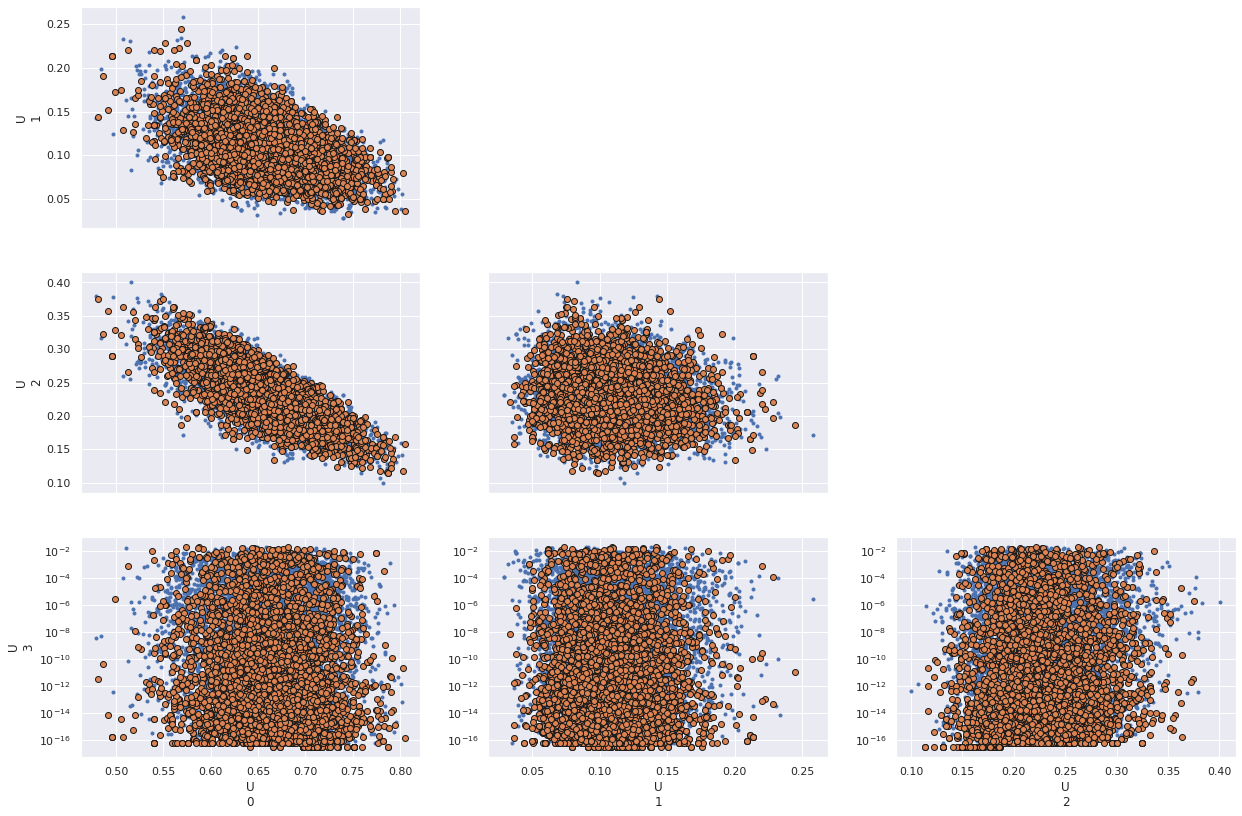

In [10]:
inference_data = az.convert_to_inference_data(fit)
ax = az.plot_pair(inference_data, var_names=('U'), divergences=True, group = 'posterior')
for i in range(3): ax[2][i].set_yscale('log')
plt.show()

Here we use a modification explained in [here]()

In [11]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [12]:
fit = sm.sampling(data=data, iter=5000, chains=4, control = {'adapt_delta': 0.9})

In [13]:
fit

Inference for Stan model: anon_model_687ec2a1287966d2c97ca899ce20f61c.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

               mean se_mean       sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
Z[1]           0.34  6.5e-4     0.05    0.25    0.31   0.34   0.37   0.44   5468    1.0
Z[2]           0.68 10.0e-4     0.07    0.52    0.63   0.68   0.73   0.81   5446    1.0
Z[3]         1.4e-3  9.5e-5   7.9e-3 2.2e-16 4.0e-13 1.2e-9 6.4e-6   0.02   6999    1.0
sens           0.77  5.5e-4     0.04    0.69    0.74   0.77    0.8   0.85   5459    1.0
spec           0.89  4.1e-4     0.03    0.83    0.87   0.89   0.91   0.94   5303    1.0
Z_prior[1]     0.39  6.1e-4     0.06    0.28    0.35   0.39   0.44   0.52   9890    1.0
Z_prior[2]     0.61  9.6e-4      0.1    0.41    0.54   0.61   0.68   0.79  10317    1.0
Z_prior[3] 2.4e-153     nan 2.4e-151     0.0     0.0    0.0    0.0    0.0    nan    1.0
sens_prior     0.7

> Why is this happening? 

Let's see what is $Z_3$! Below are the only non-zero samples!

In [14]:
samples = fit.extract()['Z_prior'][:,2]
samples = samples[samples != 0]
samples

array([9.14508822e-172, 2.43354486e-149])

And the 0.9999-quartile is `1e-55`, that is, the probability mass is all in zero! This happens because $b \gg a$. 

In [15]:
from scipy.stats import beta as beta_dist

z_3 = beta_dist(a = solution.x[-1], b = solution.x[-2])
z_3.ppf(0.9999)

1.6261926268202985e-157

Now that we understand a bit more about the problem, let's try to change a little bit the lower bound in $\alpha_4$. 

In [16]:
alpha_hat = ParameterAlpha().mix_solver(m1,m2,v1,v2,rho, lb = 0.00001)

In [17]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": alpha_hat
}

In [18]:
fit = sm.sampling(data=data, iter=5000, pars = ('sens', 'spec', 'sens_prior', 'spec_prior'))
summary = az.summary(fit)

In [19]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sens,0.797,0.040,0.720,0.866,0.001,0.0,5324.0,5323.0,1.0
spec,0.926,0.027,0.876,0.975,0.000,0.0,4994.0,4293.0,1.0
sens_prior,0.799,0.056,0.696,0.899,0.001,0.0,9541.0,9888.0,1.0
spec_prior,0.901,0.041,0.822,0.971,0.000,0.0,9947.0,9928.0,1.0


array([[<AxesSubplot:title={'center':'spec'}>,
        <AxesSubplot:title={'center':'spec'}>],
       [<AxesSubplot:title={'center':'sens'}>,
        <AxesSubplot:title={'center':'sens'}>]], dtype=object)

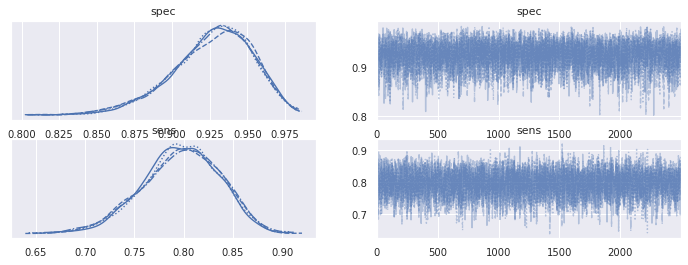

In [20]:
az.plot_trace(fit, var_names=('spec', 'sens'))

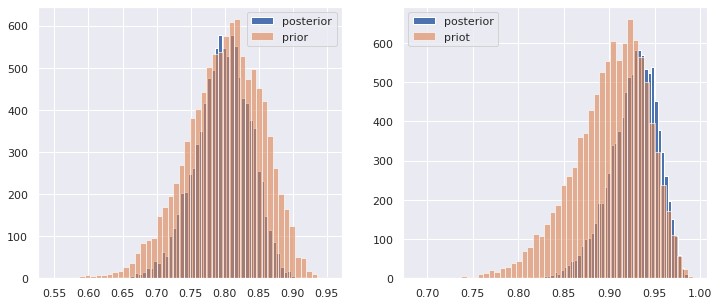

In [21]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

ax[0].hist(fit.extract()['sens'], label = 'posterior', bins = 50)
ax[1].hist(fit.extract()['spec'], label = 'posterior', bins = 50)
ax[0].hist(fit.extract()['sens_prior'], label = 'prior', alpha = 0.6, bins = 50)
ax[1].hist(fit.extract()['spec_prior'], label = 'priot', alpha = 0.6, bins = 50)

ax[0].legend()
ax[1].legend()

plt.show()

Is the posterior removing some correlation?

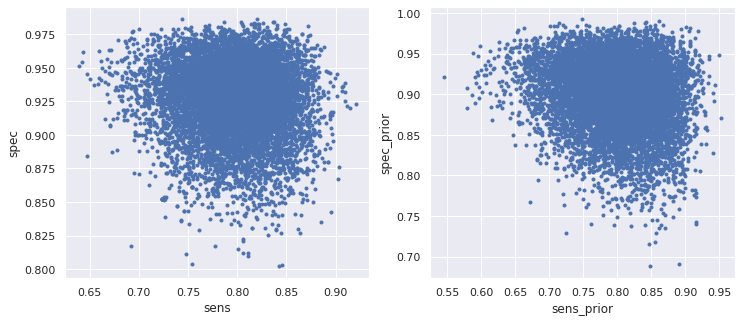

In [22]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
az.plot_pair(fit, var_names=('sens', 'spec'), ax = ax[0])
az.plot_pair(fit, var_names=('sens_prior', 'spec_prior'), ax = ax[1])
plt.show()

In [23]:
print('Prior correlation:')
print(np.corrcoef(fit.extract()['spec_prior'], fit.extract()['sens_prior'])[0,1])
print('Posterior correlation:')
print(np.corrcoef(fit.extract()['spec'], fit.extract()['sens'])[0,1])

Prior correlation:
-0.1543722978305978
Posterior correlation:
-0.07470298896461135


In [24]:
from scipy.special import expit, logit

In [25]:
m1 = 0.9
m2 = 0.9
sd1 = 0.05
sd2 = 0.05
rho = -0.3

m1 = 0.9
m2 = 0.9
sd1 = 0.91
sd2 = 0.91
rho = -0.38

x = np.random.multivariate_normal(mean = [logit(m1), logit(m2)], 
                                  cov = [[sd1**2, rho*sd1*sd2], 
                                         [rho*sd1*sd2, sd2**2]],
                                  size = 100000)

gamma_s, gamma_e = expit(x[:,0]), expit(x[:,1])                                  

In [26]:
rho_hat = np.corrcoef(gamma_e, gamma_s)[0,1]
m2_hat =np.mean(gamma_e)
m1_hat = np.mean(gamma_s)
v2_hat = np.var(gamma_e)
v1_hat = np.var(gamma_s)

print(np.corrcoef(gamma_e, gamma_s)[0,1])
print(np.mean(gamma_e))
print(np.mean(gamma_s))
print(np.std(gamma_e))
print(np.std(gamma_s))

-0.30573758665752493
0.8722603607653262
0.8709168383969681
0.1000507926475481
0.10108871423418841


In [27]:
alpha_hat = ParameterAlpha().minimizer(m1_hat,m2_hat,v1_hat,v2_hat,rho_hat, c = [1,1,1,1]).x

In [31]:
alpha_hat

array([6.35634660e+00, 1.88111096e+00, 1.89215731e+00, 4.14639575e-08])

In [45]:
BivariateBeta().moments_calculus(alpha_hat)

(0.813205401312254,
 0.8142959018442211,
 0.01364848449154252,
 0.01358700073761057,
 -0.2288767078372026)

In [50]:
n_pos = 50
n_neg = 50
Y_p = np.random.binomial(n = n_pos, p = 0.9)
Y_n = np.random.binomial(n = n_neg, p = 0.9)

In [51]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": alpha_hat
}

In [52]:
fit = sm.sampling(data=data, iter=5000, pars = ('sens', 'spec', 'sens_prior', 'spec_prior'))
summary = az.summary(fit)

In [53]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sens,0.866,0.044,0.782,0.944,0.001,0.000,4861.0,4702.0,1.0
spec,0.901,0.039,0.830,0.971,0.001,0.000,4025.0,3735.0,1.0
sens_prior,0.814,0.116,0.601,0.989,0.001,0.001,9972.0,10057.0,1.0
spec_prior,0.815,0.116,0.601,0.992,0.001,0.001,10292.0,10002.0,1.0
